In [17]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs

In [2]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [4]:
db = mg.ECMWF
db.collection_names()

['ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly',
 'ERAINT_lores_monthly_anom',
 'ERAINT_monthly',
 'system.indexes']

In [3]:
ERA_vers = 'lores'
if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_anom = 'ERAINT_monthly_anom'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_anom = 'ERAINT_lores_monthly_anom'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

In [5]:
con_anom = db[col_anom]
fo = con_anom.find_one()
pprint(fo)

{'_id': ObjectId('5a46876b8cb6b8108790f64a'),
 'al': -2.7755575615628914e-17,
 'blh': 17.16410963120117,
 'ci': 0.00479535363874195,
 'd2m': -1.381832545858515,
 'date': datetime.datetime(1979, 3, 1, 0, 0),
 'hcc': -0.003499210088334481,
 'id_grid': 1,
 'ie': 0.0,
 'ishf': -6.802686632924173,
 'istl1': -0.6554408397386169,
 'lcc': 0.09395961846049472,
 'mcc': 0.1201171896552547,
 'month': 3,
 'msl': -1286.3445712374814,
 'si10': -0.9742091376525144,
 'skt': -0.70064309868485,
 'sp': -1285.586603789896,
 'sst': -1.7053025658242404e-13,
 'stl1': -0.6713863041083243,
 't2m': -1.5088453972467164,
 'u10': -3.921264344805355,
 'v10': 2.6433083071635384,
 'year': 1979,
 'z70': -1312.067142538639}


In [7]:
con_grid = db[col_grid]
fo = con_grid.find_one()
pprint(fo)

{'_id': ObjectId('5a1882228cb6b815bce38f92'),
 'id_grid': 1,
 'loc': {'coordinates': [-180.0, 90.0], 'type': 'Point'}}


- The domain north of 20°N is chosen for EOF decomposition for Z70 hPa and SIC to focus on the extra-tropical variability 
- The area north of 20°S is chosen for SST to also include key regions of tropical SST variability
- Query id_grid encompassed in the domain. Be careful: defining a simple box won't work on the sphere, see [Antimeridian Cutting](https://tools.ietf.org/html/rfc7946#section-3.1.9). In addition, a vertice will follow the shorterst path on the sphere. Hence, we need to define a proper circular path for both latmin and latmax.



In [9]:
this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': 20, 'latmax': 90}
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)
bb = genCircle(start_lon=this_box['lonmin'], stop_lon=this_box['lonmax'], lat=10, decreasing=True)
circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                              lat = this_box['latmax'], decreasing = False)
circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                            lat = this_box['latmin'],  decreasing = True)
slp_poly = [[this_box['lonmin'], this_box['latmin']]]
slp_poly.extend(circle_north_pos)
slp_poly.extend(circle_south_neg)
this_polygon = slp_poly
geo_qry = {"loc": 
           {"$geoWithin": {
               "$geometry": {
                   "type": "Polygon",
                   "coordinates": [this_polygon]
               }
           }}}

res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
grid_df = pd.DataFrame(list(res))
grid_ids = grid_df.id_grid.values
grid_ids[:10]

array([4095, 4087, 3945, 4089, 4091, 3947, 3946, 3802, 3803, 3659])

# Query the anomaly collection for the requested id_grids

In [12]:
# Query z70 in the anomaly collection for a given day for the grid_ids
this_date = datetime(1988, 12, 1, 0, 0)
res = con_anom.find(filter = {
    "date": this_date,
    "id_grid": {"$in": grid_ids.tolist()}},
                       projection = {"_id":0, "id_grid": 1, "z70": 1})
anom_df = pd.DataFrame(list(res))
anom_df.head()

,id_grid,z70
0,1940,-1533.335412
1,1941,-1543.809612
2,1942,-1540.757342
3,1943,-1527.688561
4,1944,-1506.417387


In [13]:
# Merge anom_df with grid_df:
anom_dat = pd.merge(left=anom_df, right=grid_df, on = "id_grid")
anom_dat.head()

,id_grid,z70,loc
0,1940,-1533.335412,"{'type': 'Point', 'coordinates': [-12.5, 57.5]}"
1,1941,-1543.809612,"{'type': 'Point', 'coordinates': [-10.0, 57.5]}"
2,1942,-1540.757342,"{'type': 'Point', 'coordinates': [-7.5, 57.5]}"
3,1943,-1527.688561,"{'type': 'Point', 'coordinates': [-5.0, 57.5]}"
4,1944,-1506.417387,"{'type': 'Point', 'coordinates': [-2.5, 57.5]}"


# Plot random day

In [16]:
ras_df = anom_dat.assign(lon = list(map(lambda x: 
                                       x[0]['coordinates'][0],
                                       anom_dat[['loc']].values)),
                        lat = list(map(lambda x: 
                                       x[0]['coordinates'][1],
                                       anom_dat[['loc']].values))
                       ).pipe(lambda x: x[['lon', 'lat', 'z70']])

ras_df.head()

,lon,lat,z70
0,-12.5,57.5,-1533.335412
1,-10.0,57.5,-1543.809612
2,-7.5,57.5,-1540.757342
3,-5.0,57.5,-1527.688561
4,-2.5,57.5,-1506.417387


The solution to the rasterization problem was found here: 
https://matplotlib.org/examples/pylab_examples/griddata_demo.html

In [19]:
lons = np.arange(start=-180, stop=180+1, step=resolution)
lats = np.arange(start=-90, stop=90+1, step=resolution)
this_field = ml.griddata(x = ras_df.lon.values,
                 y = ras_df.lat.values,
                 z = ras_df.z70.values,
                 xi = lons,
                 yi = lats,
                 interp='linear')
this_field

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [1660.335637656768 1665.1266927787801 1668.8067324241856 ...,
  1648.216206437326 1654.5672854877776 --]
 [1581.5116041729343 1583.6663379945962 1585.547538755025 ...,
  1576.5407519444998 1579.3841076177196 --]
 [1499.930048025708 1499.930048025708 1499.9300480257075 ...,
  1499.930048025708 1499.930048025708 --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False  True]
 [False False False ..., False False  True]
 [False False False ..., False False  True]],
       fill_value = 1e+20)

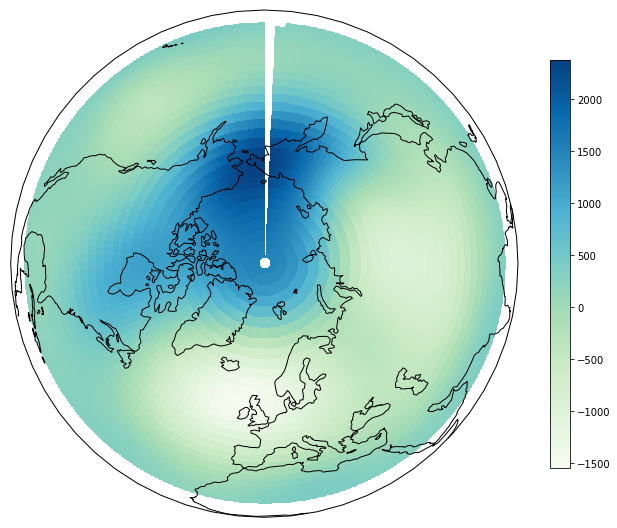

In [20]:
# Plot istself
this_proj = ccrs.Orthographic(0, 90)
fig = plt.figure(figsize=(25, 25))
ax = plt.subplot(1, 2, 1, projection=this_proj)
ax.coastlines(zorder=3)
img_proj = ccrs.PlateCarree()
img_extent = (-180, 180, -90, 90)
im = ax.imshow(this_field, 
               transform=img_proj,
               extent=img_extent, 
               origin='lower', 
               zorder=2,
               cmap='GnBu')
plt.colorbar(im, orientation='vertical',ticklocation='auto', shrink=0.3)
plt.show()

# Perform Principal Component Analyis